In [4]:
import numpy as np
import scipy
from lib.aux import PCAVector
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [9]:
rng = np.random.default_rng()

# Example 1: One-dimensional base space

## Functions for generating f, inverse, and inverse derivative

In [5]:
def getInverse(f,x):
    """Approximately inverts a function f by evaluating on the grid x and then inverting the piecewise affine interpolation."""
    y=f(x)
    fInv=scipy.interpolate.interp1d(y,x,kind="linear",assume_sorted=True)
    return fInv

def getInverseDerivative(f,x):
    """Approximately computes the inverse of the derivative of function f, by evaluation on grid x and finite differences."""
    y=f(x)
    xDiff=(x[1:]-x[:-1])/(y[1:]-y[:-1])
    xDiff=np.concatenate((xDiff,xDiff[[-1]]))
    fInvDiff=scipy.interpolate.interp1d(y,xDiff,kind="previous",assume_sorted=True)
    return fInvDiff

def getF(x0,ampl,width):
    """Returns a function f(x)=x+sum_i ampl_i * tanh((x-x_{0,i})/width_i)"""
    def f(x):
        return x+np.tanh((x.reshape((-1,1))-x0.reshape((1,-1)))/width)@ampl
    return f

In [6]:
def dens(x):
    """Evaluates the template density on grid x."""
    return 0.75*np.maximum(0,1-x**2)
    z=np.linspace(-5,5,num=1000)
    nuDat=dens(fInv(z))*fInvDiff(z)


def getSimpleF(theta1,theta2,theta3):
    """Simple parametric family from general family of f."""
    ampl=np.array([1,1,theta1])
    x0=np.array([theta2,-theta2,0])
    width=np.array([theta3,theta3,0.3])
    f=getF(x0,ampl,width)
    return f


## Basic plots of densities and deformations

### Sanity check for function, inverse, and derivative of inverse

In [5]:
psi=getSimpleF(0.5,0.7,0.2)

x=np.linspace(-1,1,num=500)
psiInv=getInverse(psi,x)
psiInvDiff=getInverseDerivative(psi,x)
y=psi(x)

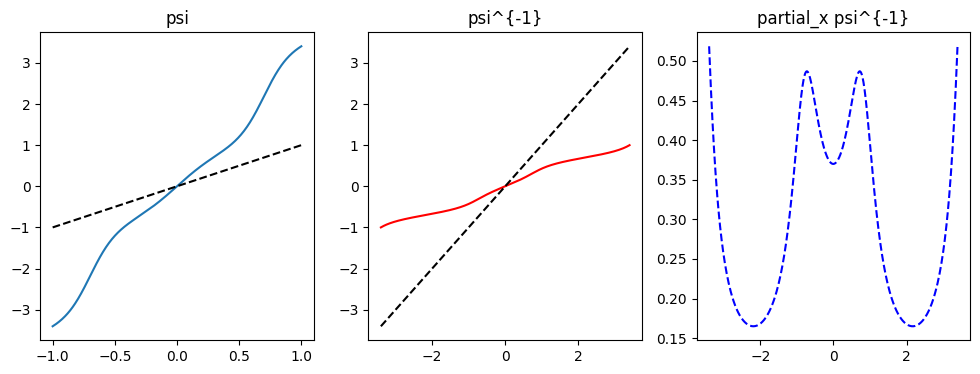

In [6]:
%matplotlib inline
fig=plt.figure(figsize=(12,4))
ax=fig.subplots(1,3)
ax[0].plot(x,psi(x),c="C0")
ax[0].plot(x,x,c="k",ls="dashed")
ax[0].set_title("psi")
ax[1].plot(y,psiInv(y),c="r")
ax[1].plot(y,y,c="k",ls="dashed")
ax[1].set_title("psi^{-1}")
ax[2].plot(y,psiInvDiff(y),c="b",ls="dashed")
ax[2].set_title("partial_x psi^{-1}")
plt.show()

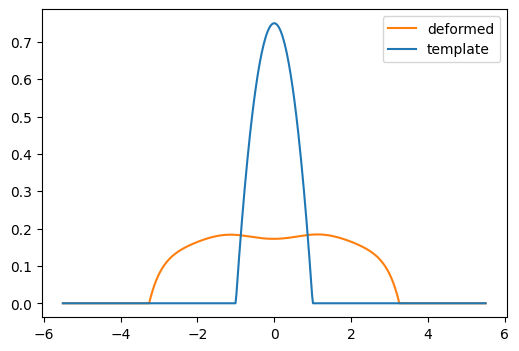

In [8]:
# push forward of density
psi=getSimpleF(0.5,0.5,0.5)
x=np.linspace(-3,3,num=1000)
psiInv=getInverse(psi,x)
psiInvDiff=getInverseDerivative(psi,x)
y=psi(x)

%matplotlib inline
fig=plt.figure(figsize=(6,4))
ax=fig.subplots(1,1)
ax.plot(y,dens(psiInv(y))*psiInvDiff(y),c="C1",label="deformed")
ax.plot(y,dens(y),c="C0",label="template")
plt.legend()
plt.show()

In [9]:
# integration test, output should be approximately 1
z=np.linspace(-5,5,num=1000)
lambdaDeformed=dens(psiInv(z))*psiInvDiff(z)
diffZ=z[1]-z[0]
print(np.sum(lambdaDeformed)*diffZ)

1.000022651187311


### Interactive plot

interactive(children=(FloatSlider(value=0.5, description='theta1', max=1.0), FloatSlider(value=0.5, descriptio…

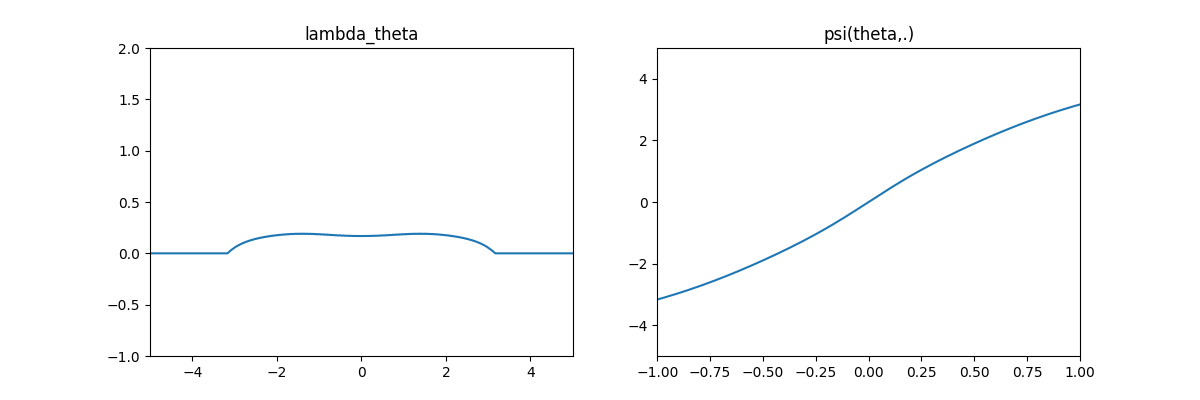

In [11]:
%matplotlib widget
fig = plt.figure(figsize=(12,4))
ax = fig.subplots(1,2)
line, = ax[0].plot([0,1],[0,1])
ax[0].set_xlim([-5,5])
ax[0].set_ylim([-1,2])
ax[0].set_title("lambda_theta")

line2, = ax[1].plot([0,1],[0,1])
ax[1].set_xlim([-1,1])
ax[1].set_ylim([-5,5])
ax[1].set_title("psi(theta,.)")

def update(theta1,theta2,theta3):
    f=getSimpleF(theta1,theta2,theta3)

    x=np.linspace(-5,5,num=500)
    fInv=getInverse(f,x)
    fInvDiff=getInverseDerivative(f,x)
    y=f(x)
    z=np.linspace(-5,5,num=1000)
    nuDat=dens(fInv(z))*fInvDiff(z)

    line.set_data(z,nuDat)
    line2.set_data(x,f(x))
    ax[0].autoscale_view()
    ax[1].autoscale_view()
    fig.canvas.draw_idle()
    #print("x")
    
widgets.interact(update, theta1 = (0.,1.), theta2 = (0.,1.), theta3 = (0.2,1));


In [12]:
plt.close()

### Show some exemplary densities

In [13]:
# generate plot data

# number of densities
nDens=20
# random parameters
thetaList=rng.random(size=(nDens,3))
thetaList[:,2]=0.2+0.8*thetaList[:,2]

# grid for computing inverse and derivative
x=np.linspace(-5,5,num=5000)
# grid on which to evaluate push-forward
z=np.linspace(-4,4,num=500)
muDat=np.zeros((nDens,z.shape[0]))
for j in range(nDens):
    theta=thetaList[j]
    f=getSimpleF(*theta)
    fInv=getInverse(f,x)
    fInvDiff=getInverseDerivative(f,x)
    muDat[j,:]=dens(fInv(z))*fInvDiff(z)
    

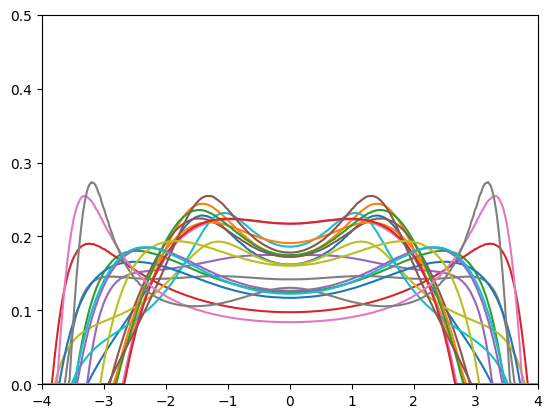

In [16]:
%matplotlib inline
for y in muDat:  
    plt.plot(z,y)
plt.xlim([-4,4])
plt.ylim([0,0.5])
plt.show()

In [17]:
# export figure data
#np.savez("fig/data/f1_densities.npz",z=z,nuDat=nuDat)

## Tangent space analysis

### Create data

In [18]:
# number of grid points for discretization of psi
nDisc=2500
# number of samples for tangent space analysis
nSamples=500
# list of time parameters for tangent space analysis
TList=np.logspace(0,-2,num=21)
nT=len(TList)


# grid and template density
x=np.linspace(-1,1,num=nDisc)
deltax=x[1]-x[0]
mu=dens(x)*deltax
# fill first and lass entry of with something non-zero
mu=np.maximum(mu,1E-100)


# support point for tangent space analysis
theta0=np.array([0.5,0.5,0.6])
f0=getSimpleF(*theta0)
f0Dat=f0(x)



# random values uniformly in [-1,1]
# the three parameters lie in [0,1] x [0,1] x [0.2,1], so we rescale these below
noise=2*rng.random((nSamples,3))-1

# now for each time parameter, create suitable rescaled tangent vectors
thetaList=np.zeros((nT,nSamples,3))
for i,t in enumerate(TList):
    thetaList[i,:,0]=theta0[0]+t*0.5*noise[:,0]
    thetaList[i,:,1]=theta0[1]+t*0.5*noise[:,1]
    thetaList[i,:,2]=theta0[2]+t*0.4*noise[:,2]

### Spectral analysis

In [20]:
# do spectral analysis of span operator F(W^t) for all t
eigvalList=[]
eigvecList=[]
# iterate over t
for i,t in enumerate(TList):
    print(i)
    # generate w-vectors T_t is given y psi(theta,psi^{-1}(theta_0,.))
    # but we can simply do this in the tangent space of the template, since Wasserstein space is flat for d=1
    # (or just apply a push-foward by psi(theta_0,.) to all formulas
    vecList=np.array([((getSimpleF(*theta))(x)-f0Dat)/t for theta in thetaList[i]]).reshape((nSamples,nDisc,1))
    eigval,eigvec=PCAVector(vecList, mu)
    order=np.argsort(-eigval)
    eigvalList.append(eigval[order])
    eigvecList.append(eigvec[order])

eigvalList=np.array(eigvalList)
eigvecList=np.array(eigvecList)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


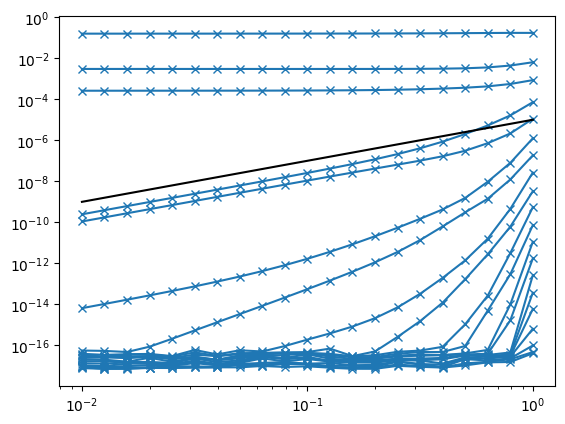

In [21]:
# spectral analysis of span operator F(W^t)
%matplotlib inline
keep=20
for vals in eigvalList[:,:keep].T:
    plt.plot(TList,vals,marker="x",c="C0")

plt.plot(TList,1E-5*TList**2,c="k")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [11]:
# export plot data
#np.savez("fig/data/f1_eigenvalues.npz",eigvalList=eigvalList,TList=TList)

### Convergence of infinitesimal distance and deformation

In [23]:
# compare v=B_theta eta against w_t = (T_t-id)/t
# for d=1 this just reduces to a comparison of the derivative of psi vs a finite difference approximation

In [24]:
# delta for finite diff differentiation
delta=1E-7

# for how many samples should we show this plot?
keep=20
errList=np.zeros((nT,keep),dtype=np.double)

for i,t in enumerate(TList):
    print(i)
    for j in range(keep):
        theta=thetaList[i,j]
        deltaTheta=theta-theta0
        f0=getSimpleF(*theta0)
        f1=getSimpleF(*(theta0+delta*deltaTheta))
        f2=getSimpleF(*theta)
        v=(f1(x)-f0(x))/delta/t
        w=(f2(x)-f0(x))/t
        errList[i,j]=np.sum((w-v)**2*mu)**0.5

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


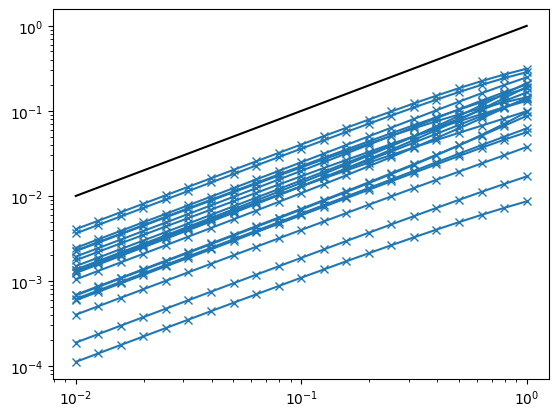

In [25]:
%matplotlib inline
keep=20
for j in range(keep):
    plt.plot(TList,errList[:,j],c="C0",marker="x")
plt.plot(TList,TList,c="k")
plt.xscale("log")
plt.yscale("log")
plt.show()


In [26]:
# export data
#np.savez("fig/data/f1_w_convergence.npz",TList=TList,errList=errList)